### Vignette for Cao et al., 2017

This notebook will show you how to work with the C. elegans L2-stage sci-RNA-seq data from Cao et al., 2017. 
<br> It aims to cover the following use cases:

1. Accessing the raw data
1. Exploring the expression pattern of a gene of interest
1. Finding differentially expressed genes between subsets of cells
1. Re-clustering subsets of the data using t-SNE

You'll will need the `dplyr` and `ggplot` R packages, as well as the `monocle` package at version 2.3.5. Monocle is a comprehensive package for single cell analysis developed by the Trapnell lab. Monocle version 2.3.5 is the version that was used for the paper. The source code for Monocle 2.3.5 is available at:

https://github.com/cole-trapnell-lab/single-cell-worm/Waterston_Data/monocle_2.3.5.tar.gz

To install it, open a command line (outside this Jupyter notebook) and run:

```
curl -O https://cole-trapnell-lab.github.io/single-cell-worm/downloads/monocle_2.3.5.tar
R CMD INSTALL monocle_2.3.5.tar
```

More recent versions of Monocle will produce different results for use case 4 (re-clustering with t-SNE) due to changes in how we preprocess the data before running t-SNE. We will update this vignette when we release the next version of Monocle, 2.6.0, to support the new version.

In [ ]:
suppressPackageStartupMessages({
    library(dplyr)
    library(ggplot2)
    library(monocle)
})

In [ ]:
sessionInfo()

This RData file contains both the data and some utility functions to help navigate it.

In [2]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/Cao_et_al_2017_vignette.RData",
    destfile = "Cao_et_al_2017_vignette.RData")

In [3]:
load("Cao_et_al_2017_vignette.RData")

- cds is a Monocle CellDataSet object containing the single cell RNA-seq data from the main L2-stage C. elegans experiment described in Cao et al., along with annotations.
- cds.neurons is a re-clustered subset of the neuronal cells from cds.
- cds.experiment.2 has data from the second C. elegans experiment described in Cao et al.. This includes intestine cells that were missed in the first experiment, but the data overall is lower quality than the first experiment. In the manuscript, we only included the intestine cells from this experiment and excluded the rest.

### Use case 1: accessing the raw data

The raw gene-by-cell UMI (unique molecular identifier) count matrix for a CellDataSet can be accessed using the `exprs` function. It is stored as a sparse matrix object ("`.`" = 0)

Note that if you need "even rawer" data (FASTQ files), they are available at the Gene Expression Omnibus (www.ncbi.nlm.nih.gov/geo) under accession code GSE98561.

If you aren't familiar with working with single cell RNA-seq data, we highly recommend that you take a look at the examples and utility functions presented in the other sections of this document instead of trying to dive in to the raw data directly.

In [4]:
exprs(cds)[1:3, 1:3]

3 x 3 sparse Matrix of class "dgCMatrix"
               cele-001-001.CATGACTCAA cele-001-001.AAGACGGCCA
WBGene00000001                       .                       .
WBGene00000002                       .                       .
WBGene00000003                       .                       .
               cele-001-001.GCCAACGCCA
WBGene00000001                       .
WBGene00000002                       .
WBGene00000003                       .

The `fData` function is used to access gene annotations.

In [5]:
fData(cds)[1:3,]

,gene_id,symbol,num_cells_expressed
WBGene00000001,WBGene00000001,aap-1,1016
WBGene00000002,WBGene00000002,aat-1,354
WBGene00000003,WBGene00000003,aat-2,897


The `pData` function is used to access cell annotations.
- n.umi is the number of unique molecular identifiers observed to be expressed by a given cell.
- Size_Factor is n.umi divided by the media n.umi across all cells.
- tsne_1 and tsne_2 are the coordinates for the cell in the t-SNE dimensionality reduction.
- Cluster is the cluster id assigned by density peak clustering algorithm.
- cell.type and tissue are the annotations that we used throughout the analysis of Cao et al.

In [6]:
pData(cds)[1:3,]

,cell,n.umi,plate,Size_Factor,num_genes_expressed,tsne_1,tsne_2,Cluster,peaks,halo,delta,rho,cell.type,tissue
cele-001-001.CATGACTCAA,cele-001-001.CATGACTCAA,144,001,0.2368328,89,5.4866377,14.67085,20,FALSE,TRUE,0.02491657,893.9855,Unclassified neurons,Neurons
cele-001-001.AAGACGGCCA,cele-001-001.AAGACGGCCA,790,001,1.2992911,419,-3.8619751,-27.63448,6,FALSE,TRUE,0.40961274,812.2076,Germline,Gonad
cele-001-001.GCCAACGCCA,cele-001-001.GCCAACGCCA,832,001,1.3683674,338,-0.5594413,41.98569,13,FALSE,TRUE,0.04445184,240.2908,Intestinal/rectal muscle,Intestinal/rectal muscle


neuron.type in pData(cds.neurons) is the annotation used in Figure 4 of Cao et al.

In [7]:
pData(cds.neurons)[1:3,]

,cell,n.umi,plate,Size_Factor,num_genes_expressed,tsne_1,tsne_2,Cluster,peaks,halo,delta,rho,tissue,cell.type,neuron.type
cele-001-001.CATGACTCAA,cele-001-001.CATGACTCAA,144,001,0.2368328,89,0.9574604,0.8288424,11,FALSE,TRUE,0.37046400,108.71265,Neurons,Unclassified neurons,Cholinergic (11)
cele-001-001.AACTACGGCT,cele-001-001.AACTACGGCT,201,001,0.3305791,129,-3.0567593,-41.4083795,8,FALSE,FALSE,0.25861943,70.88069,Neurons,Ciliated sensory neurons,ASI/ASJ
cele-001-001.GAGGCTTATT,cele-001-001.GAGGCTTATT,117,001,0.1924267,76,-18.5689290,-33.9833909,39,FALSE,TRUE,0.02962754,37.29414,Neurons,Ciliated sensory neurons,AFD


### Use case 2: exploring the expression pattern of a gene of interest

The `show.expr.info` function returns statistics related to the expression of a given gene in tabular form. The first argument is the gene name. The second argument specifies whether to show statistics at the level of tissues, cell types, or neuron (sub)-types. See the examples below.

The function returns a data frame with five columns:
- facet -- the tissue / cell type / neuron type
- tpm -- the expression of the given gene in the facet in TPM (transcripts per million).
- prop.cells.expr -- the proportion of cells in the facet that express at least one UMI (unique molecular identifier) for the given gene. Note that cells in different facets can have very different average number of UMIs per cell, so TPM is the better measure of relative expression.
- n.umi -- the number of UMIs (unique molecular identifiers) observed for the given gene in the facet. This is the "sample size" from which the TPM value is computed.
- total.n.umi.for.facet -- the total number of UMIs observed across all genes for all cells in the facet.

Note that low levels of expression of a given gene in cell types you would not expect may be due to leakage of RNA in the fixed cells. For this experiment, based on the expression patterns for a few marker genes, we estimate that the background level of expression you will observe randomly in cells that do not truly express a given gene is ~1-2% of the expression of the highest-expressing cell type.

In [8]:
show.expr.info("emb-9", "tissue")

facet,tpm,prop.cells.expr,n.umi,total.n.umi.for.facet
Body wall muscle,7972.27222,0.96451347,157028,19390434
Gonad,390.16652,0.03757116,3597,11166871
Intestine,97.88569,0.09775967,102,1230975
Neurons,89.83882,0.01406926,187,2203067
Glia,72.96189,0.02148228,39,787560
Pharynx,49.97025,0.01237113,48,1122443
Hypodermis,47.05950,0.01821904,158,5821384


In [9]:
show.expr.info("emb-9", "cell type") %>% head(10)

facet,tpm,prop.cells.expr,n.umi,total.n.umi.for.facet
Distal tip cells,16165.1598,0.97520661,3405,202581
Body wall muscle,7972.2722,0.96451347,157028,19390434
Intestinal/rectal muscle,5211.8861,0.84740260,2622,439170
Sex myoblasts,218.2425,0.14776632,75,377288
Pharyngeal neurons,165.1210,0.01592357,14,85381
Other interneurons,137.8986,0.02483070,17,172852
Socket cells,123.7517,0.02793296,26,184774
Coelomocytes,115.4683,0.02503682,71,544263
Non-seam hypodermis,102.4186,0.02006689,56,1059546
Somatic gonad precursors,102.1766,0.06376812,75,823856


In [10]:
show.expr.info("R102.2", "neuron type") %>% head(10)

facet,tpm,prop.cells.expr,n.umi,total.n.umi.for.facet
Cluster 21,9807.74014,0.91588785,446,49587
Cluster 16,8266.64832,0.66025641,363,47719
ASK,6720.61429,0.81944444,155,24157
ASI/ASJ,6482.22237,0.74358974,239,40396
ASG,2121.04289,0.39534884,48,26295
ASEL,1670.50501,0.37837838,17,11042
ASER,795.91129,0.28571429,16,15324
AWB/AWC,85.09161,0.02380952,4,23186
Cholinergic (15),60.56935,0.01538462,1,14463
Pharyngeal (33),58.35581,0.02857143,2,25101


Note that you can see the source code for any of the utility functions used in this vignette. Just run the function with name no parentheses.

In [11]:
show.expr.info

function(gene, expr.info) {
    if (class(expr.info) == "character") {
        expr.info = gsub("[.]", " ", tolower(expr.info))
        if (expr.info == "tissue")
            expr.info = tissue.expr.info
        else if (expr.info == "cell type")
            expr.info = cell.type.expr.info
        else if (expr.info == "neuron type")
            expr.info = neuron.type.expr.info
    }
    
    gene.id = get.gene.id(gene, fData.df = expr.info$gene.annotations)
    data.frame(
        facet = names(expr.info$tpm[gene.id,]),
        tpm = expr.info$tpm[gene.id,],
        prop.cells.expr = expr.info$prop.cells.expr[gene.id,],
        n.umi = expr.info$n.umi[gene.id,],
        total.n.umi.for.facet = expr.info$total.n.umi.for.facet) %>%
    arrange(-tpm)
}

The `plot.expr` function can be used to highlight cells that express a given gene on the t-SNE map.
- Cells that do not express the gene will be colored grey. They are made semi-transparent so as to better highlight the cells that do express the gene.
- Cells that express the gene will be colored according to their cell type. The top 4 highest-expressing cell types will be assigned distinct colors. Other cell types will be lumped together.
- Cells in the "Failed QC" category are those that express the gene, but are excluded from the analysis due to either having an unusually low UMI count or being a likely doublet.

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

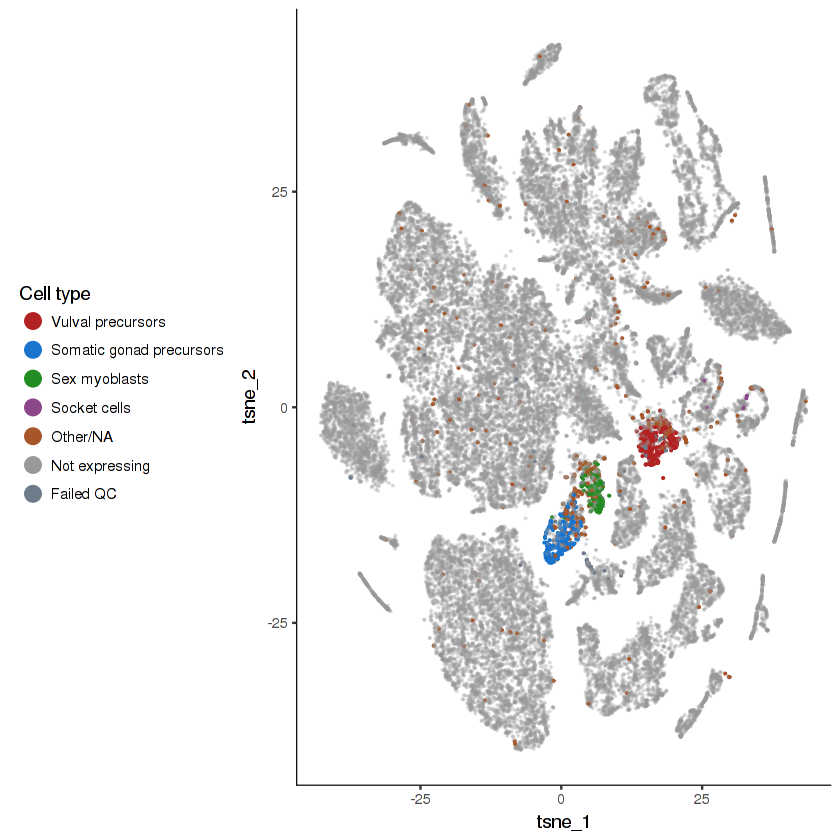

In [12]:
plot.expr(cds, "lin-12")

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

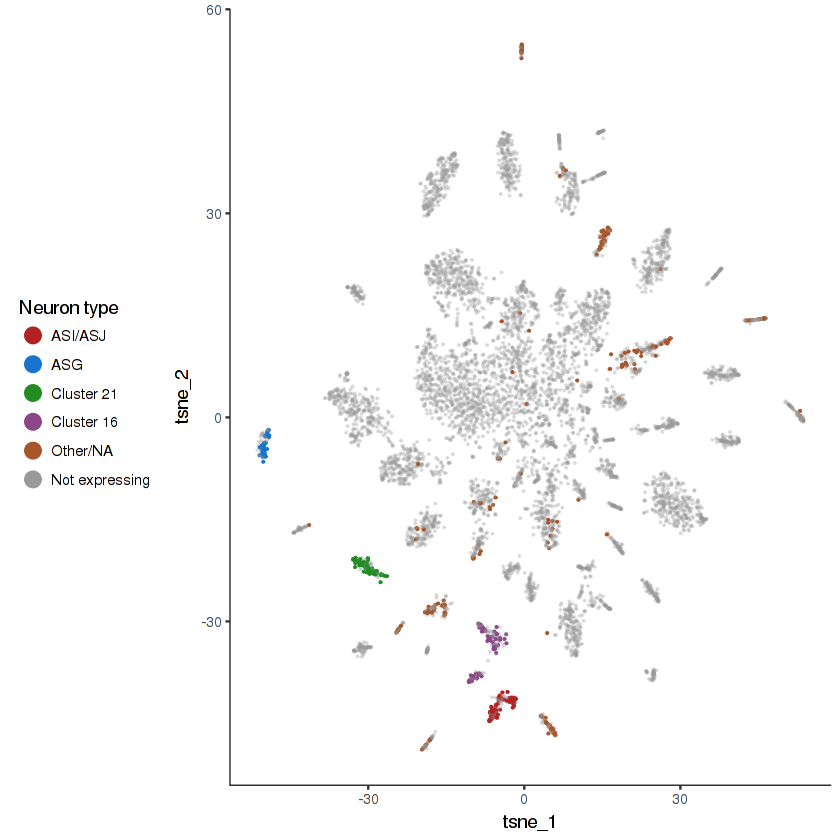

In [13]:
plot.expr(cds.neurons, "che-3")

### Use case 3: testing for differential expression between subsets of cells

We've defined a function `two.set.differential.gene.test` that finds and reports statistics on differentially expressed genes (DEG) that distinguish between two defined sets of cells. This is a wrapper that just adds a bit of functionality around Monocle's `differentialGeneTest` function.

`two.set.differential.gene.test` takes four arguments:
1. cds -- a CellDataSet object that includes both sets of cells you wish to compare
1. set.1.filter -- a boolean vector of length ncol(cds) indicating which cells should be in Set 1
1. set.2.filter -- a boolean vector of length ncol(cds) indicating which cells should be in Set 2
1. formal -- if TRUE, p-values and q-values are computed for differential gene expression and genes are ranked by q-value. if FALSE, no formal statistical test is performed and genes are heuristically ranked. formal = F makes the function run much, much faster.

**Warning**: if you run `two.set.differential.gene.test` on large sets of cells (>10000-ish), it may take a bunch of memory.

The utility functions `is.tissue`, `is.cell.type`, and `is.neuron.type` may be used to create the boolean vectors required for the `set.1.filter` and `set.2.filter` parameters. Each function takes a CellDataSet and a string and tests for each cell whether its tissue / cell type / neuron type is defined (not NA) and equal to the given value.

In [14]:
is.tissue

function(cds, x) {
    with(pData(cds), !is.na(tissue) & tissue == x)
}

In [15]:
head(is.tissue(cds, "Gonad"))

[1] FALSE  TRUE FALSE FALSE FALSE  TRUE

In [16]:
sum(is.tissue(cds, "Gonad"))

[1] 5628

In [17]:
sum(is.cell.type(cds, "Distal tip cells"))
sum(is.neuron.type(cds.neurons, "ASEL"))

[1] 129

[1] 37

In [18]:
tissues

[1] "Body wall muscle" "Pharynx"          "Hypodermis"       "Neurons"         
[5] "Glia"             "Gonad"            "Intestine"

In [19]:
cell.types

[1] "Am/PH sheath cells"       "Body wall muscle"        
 [3] "Canal associated neurons" "Cholinergic neurons"     
 [5] "Ciliated sensory neurons" "Coelomocytes"            
 [7] "Distal tip cells"         "Dopaminergic neurons"    
 [9] "Excretory cells"          "flp-1(+) interneurons"   
[11] "GABAergic neurons"        "Germline"                
[13] "Intestinal/rectal muscle" "Intestine"               
[15] "Non-seam hypodermis"      "Other interneurons"      
[17] "Oxygen sensory neurons"   "Pharyngeal epithelia"    
[19] "Pharyngeal gland"         "Pharyngeal muscle"       
[21] "Pharyngeal neurons"       "Rectum"                  
[23] "Seam cells"               "Sex myoblasts"           
[25] "Socket cells"             "Somatic gonad precursors"
[27] "Touch receptor neurons"   "Vulval precursors"

In [20]:
neuron.types

[1] "AFD"              "ASEL"             "ASER"             "ASG"             
 [5] "ASI/ASJ"          "ASK"              "AWA"              "AWB/AWC"         
 [9] "BAG"              "CAN"              "Cholinergic (11)" "Cholinergic (15)"
[13] "Cholinergic (23)" "Cholinergic (24)" "Cholinergic (26)" "Cholinergic (29)"
[17] "Cholinergic (3)"  "Cholinergic (35)" "Cholinergic (36)" "Cluster 10"      
[21] "Cluster 13"       "Cluster 16"       "Cluster 17"       "Cluster 21"      
[25] "Cluster 25"       "Cluster 27"       "Cluster 40"       "Cluster 5"       
[29] "Dopaminergic"     "DVA"              "flp-1(+)"         "GABAergic"       
[33] "Pharyngeal (33)"  "Pharyngeal (37)"  "PVC/PVD"          "RIA"             
[37] "RIC"              "SDQ/ALN/PLN"      "Touch receptor"   "URX/AQR/PQR"

In [21]:
ASEL.vs.ASER.DEG = two.set.differential.gene.test(
    cds.neurons, is.neuron.type(cds.neurons, "ASEL"), is.neuron.type(cds.neurons, "ASER"))

# of cells in set 1: 37
# of cells in set 2: 35


`two.set.differential.gene.test` returns the following statistics:
- set.1.umi -- the number of UMI (unique molecular identifiers) observed for the gene in Set 1
- set.2.umi -- the number of UMI (unique molecular identifiers) observed for the gene in Set 2
- set.1.tpm -- gene expression in Set 1 in TPM (transcripts per million)
- set.2.tpm -- gene expression in Set 2 in TPM (transcripts per million)
- higher.expr -- which set has higher expression (TPM)
- log2.ratio -- log2(TPM of higher expressing set / (TPM of lower expressing set + 1))
- precision -- (# of cells expressing gene in higher expressing set) / (total # of cells expressing gene)
- recall -- (# of cells expressing gene in higher expressing set) / (total # of cells in higher expressing set)
- f.score -- harmonic mean of precision and recall. genes are sorted by this metric

In [22]:
ASEL.vs.ASER.DEG %>% head()

gene,set.1.n.umi,set.2.n.umi,set.1.tpm,set.2.tpm,higher.expr,log2.ratio,precision,recall,f.score
tank-1,20,570,1794.188,36169.778,Set 2,4.332578,0.8536585,1.0000000,0.9210526
gcy-22,0,129,0.000,8862.360,Set 2,13.113475,1.0000000,0.8000000,0.8888889
gei-3,10,166,1095.928,12076.301,Set 2,3.460638,0.9090909,0.8571429,0.8823529
gcy-3,0,147,0.000,9593.506,Set 2,13.227842,1.0000000,0.7428571,0.8524590
gcy-6,66,0,6909.705,0.000,Set 1,12.754408,1.0000000,0.7297297,0.8437500
T27C4.1,30,164,3210.293,11338.218,Set 2,1.819968,0.6808511,0.9142857,0.7804878


In [23]:
ASEL.vs.ASER.DEG %>% filter(higher.expr == "Set 1") %>% head()

gene,set.1.n.umi,set.2.n.umi,set.1.tpm,set.2.tpm,higher.expr,log2.ratio,precision,recall,f.score
gcy-6,66,0,6909.705,0.000,Set 1,12.754408,1.0000000,0.7297297,0.8437500
gcy-17,69,0,6553.874,0.000,Set 1,12.678132,1.0000000,0.6216216,0.7666667
crh-1,58,12,5675.336,800.504,Set 1,2.823924,0.8333333,0.6756757,0.7462687
gcy-20,53,0,5339.037,0.000,Set 1,12.382364,1.0000000,0.5945946,0.7457627
gcy-7,39,0,3709.660,0.000,Set 1,11.857071,1.0000000,0.5675676,0.7241379
unc-44,88,45,7647.438,2915.088,Set 1,1.390942,0.6000000,0.8108108,0.6896552


Running `two.set.differential.gene.test` with `formal = T` will compute q-values (the false detection rate at which a gene can be considered to be differentially expressed between the two sets). This is very slow however, so we recommend not using it for exploratory analysis and only using it after you've found something interesting and want to verify that the finding is statistically robust.

In [24]:
system.time({

ASEL.vs.ASER.DEG = two.set.differential.gene.test(
    cds.neurons, is.neuron.type(cds.neurons, "ASEL"), is.neuron.type(cds.neurons, "ASER"),
    formal = T, cores = min(16, detectCores()))
    
})

# of cells in set 1: 37
# of cells in set 2: 35
756 genes expressed in at least 5 cells across both sets
Computing differential expression p-values
Warning message:
“closing unused connection 19 (<-localhost:11963)”Warning message:
“closing unused connection 18 (<-localhost:11963)”Warning message:
“closing unused connection 17 (<-localhost:11963)”Warning message:
“closing unused connection 16 (<-localhost:11963)”Warning message:
“closing unused connection 15 (<-localhost:11963)”Warning message:
“closing unused connection 14 (<-localhost:11963)”Warning message:
“closing unused connection 13 (<-localhost:11963)”Warning message:
“closing unused connection 12 (<-localhost:11963)”Warning message:
“closing unused connection 11 (<-localhost:11963)”Warning message:
“closing unused connection 10 (<-localhost:11963)”Warning message:
“closing unused connection 9 (<-localhost:11963)”Warning message:
“closing unused connection 8 (<-localhost:11963)”Warning message:
“closing unused connection 7 (<-l

   user  system elapsed 
 20.061   3.745 150.409 

In [25]:
ASEL.vs.ASER.DEG %>% head()

gene,set.1.n.umi,set.2.n.umi,set.1.tpm,set.2.tpm,higher.expr,log2.ratio,precision,recall,f.score,p.val,q.val
gcy-3,0,147,0.000,9593.506,Set 2,13.227842,1.0000000,0.7428571,0.8524590,1.238145e-11,9.360380e-09
gcy-22,0,129,0.000,8862.360,Set 2,13.113475,1.0000000,0.8000000,0.8888889,2.699776e-11,1.020515e-08
tank-1,20,570,1794.188,36169.778,Set 2,4.332578,0.8536585,1.0000000,0.9210526,4.789133e-11,1.206861e-08
gcy-6,66,0,6909.705,0.000,Set 1,12.754408,1.0000000,0.7297297,0.8437500,1.053208e-08,1.487185e-06
gcy-17,69,0,6553.874,0.000,Set 1,12.678132,1.0000000,0.6216216,0.7666667,1.180306e-08,1.487185e-06
K09F6.9,0,75,0.000,5925.954,Set 2,12.532832,1.0000000,0.5428571,0.7037037,1.161684e-08,1.487185e-06


`two.set.differential.gene.test` can be used to compare a specific cell type vs. all other cells.

In [26]:
touch.receptor.neuron.DEG = two.set.differential.gene.test(
    cds,
    is.cell.type(cds, "Touch receptor neurons"),
    !is.cell.type(cds, "Touch receptor neurons") & is.tissue(cds, "Neurons"))

# of cells in set 1: 334
# of cells in set 2: 7058


In [27]:
touch.receptor.neuron.DEG %>% filter(higher.expr == "Set 1") %>% head()

gene,set.1.n.umi,set.2.n.umi,set.1.tpm,set.2.tpm,higher.expr,log2.ratio,precision,recall,f.score
mec-17,2720,118,24033.028,39.202902,Set 1,9.223503,0.9009288,0.8712575,0.8858447
mec-18,796,49,7040.671,17.963804,Set 1,8.536321,0.9094828,0.6317365,0.7455830
mtd-1,443,15,4025.528,5.513083,Set 1,9.271622,0.9476440,0.5419162,0.6895238
mec-7,4418,743,35936.308,239.162028,Set 1,7.225290,0.5563771,0.9011976,0.6880000
mec-1,1717,695,16304.188,328.822706,Set 1,5.627408,0.4609610,0.9191617,0.6140000
mec-9,726,337,7088.606,182.571539,Set 1,5.271088,0.5126263,0.6077844,0.5561644


*tni-3* is a troponin that is expressed in body wall muscle (BWM) in the head, but not in the posterior.
<br>*cwn-1* and *egl-20* are Wnt ligands that are expressed in posterior BWM, but not anterior BWM.
<br>Using these genes as markers, let's look for differentially expressed genes between anterior and posterior BWM.

In [28]:
BWM.anterior.vs.posterior.DEG = two.set.differential.gene.test(
    cds,
    is.cell.type(cds, "Body wall muscle") & expresses.gene(cds, "tni-3"),
    is.cell.type(cds, "Body wall muscle") & (expresses.gene(cds, "cwn-1") | expresses.gene(cds, "egl-20")))

# of cells in set 1: 1254
# of cells in set 2: 1290


In [29]:
BWM.anterior.vs.posterior.DEG$higher.expr = ifelse(
    BWM.anterior.vs.posterior.DEG$higher.expr == "Set 1",
    "Anterior BWM", "Posterior BWM")

In [30]:
BWM.anterior.vs.posterior.DEG %>% head()

gene,set.1.n.umi,set.2.n.umi,set.1.tpm,set.2.tpm,higher.expr,log2.ratio,precision,recall,f.score
tni-3,6981,93,3804.24742,18.57887,Anterior BWM,7.602169,0.9819890,1.0000000,0.9909127
cwn-1,59,3113,13.99762,1311.17230,Posterior BWM,6.449980,0.9821732,0.8968992,0.9376013
T21B6.3,13869,271,5966.03306,60.20010,Anterior BWM,6.607094,0.9553265,0.8867624,0.9197684
him-4,1366,12029,595.78605,3527.26462,Posterior BWM,2.563264,0.8371408,0.8806202,0.8583302
lec-5,862,9838,230.36587,2677.35386,Posterior BWM,3.532560,0.8626374,0.8519380,0.8572543
F41C3.5,2478,21353,592.75881,5575.97179,Posterior BWM,3.231274,0.7865412,0.8426357,0.8136228


In [31]:
BWM.anterior.vs.posterior.DEG %>% filter(precision >= 0.95, higher.expr == "Anterior BWM") %>% head(10)

gene,set.1.n.umi,set.2.n.umi,set.1.tpm,set.2.tpm,higher.expr,log2.ratio,precision,recall,f.score
tni-3,6981,93,3804.24742,18.5788744,Anterior BWM,7.602169,0.9819890,1.0000000,0.9909127
T21B6.3,13869,271,5966.03306,60.2000953,Anterior BWM,6.607094,0.9553265,0.8867624,0.9197684
glc-4,684,37,310.53057,11.4323046,Anterior BWM,4.642570,0.9506849,0.2767145,0.4286597
tre-3,555,5,214.79033,0.6369876,Anterior BWM,7.035742,0.9852399,0.2129187,0.3501639
F48E3.8,402,1,144.96720,0.1162907,Anterior BWM,7.020870,0.9947917,0.1523126,0.2641770
dpyd-1,289,6,91.93291,0.9050051,Anterior BWM,5.592715,0.9740933,0.1499203,0.2598480
ceh-34,307,2,131.08432,0.2528051,Anterior BWM,6.709189,0.9885057,0.1371611,0.2408964
seb-2,201,5,85.08025,0.6848107,Anterior BWM,5.658166,0.9750000,0.1244019,0.2206506
sfrp-1,335,2,145.18286,0.2754131,Anterior BWM,6.830763,0.9863946,0.1156300,0.2069950
F35C11.5,168,1,67.97453,0.5230727,Anterior BWM,5.479937,0.9923664,0.1036683,0.1877256


*R102.2* is expressed in nine specific pairs of ciliated sensory neurons (http://www.wormbase.org/species/c_elegans/gene/WBGene00011289). We have identified some of these in this dataset, but others remain ambiguous.

In [32]:
show.expr.info("R102.2", "neuron type") %>% head(8)

facet,tpm,prop.cells.expr,n.umi,total.n.umi.for.facet
Cluster 21,9807.74014,0.91588785,446,49587
Cluster 16,8266.64832,0.66025641,363,47719
ASK,6720.61429,0.81944444,155,24157
ASI/ASJ,6482.22237,0.74358974,239,40396
ASG,2121.04289,0.39534884,48,26295
ASEL,1670.50501,0.37837838,17,11042
ASER,795.91129,0.28571429,16,15324
AWB/AWC,85.09161,0.02380952,4,23186


Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

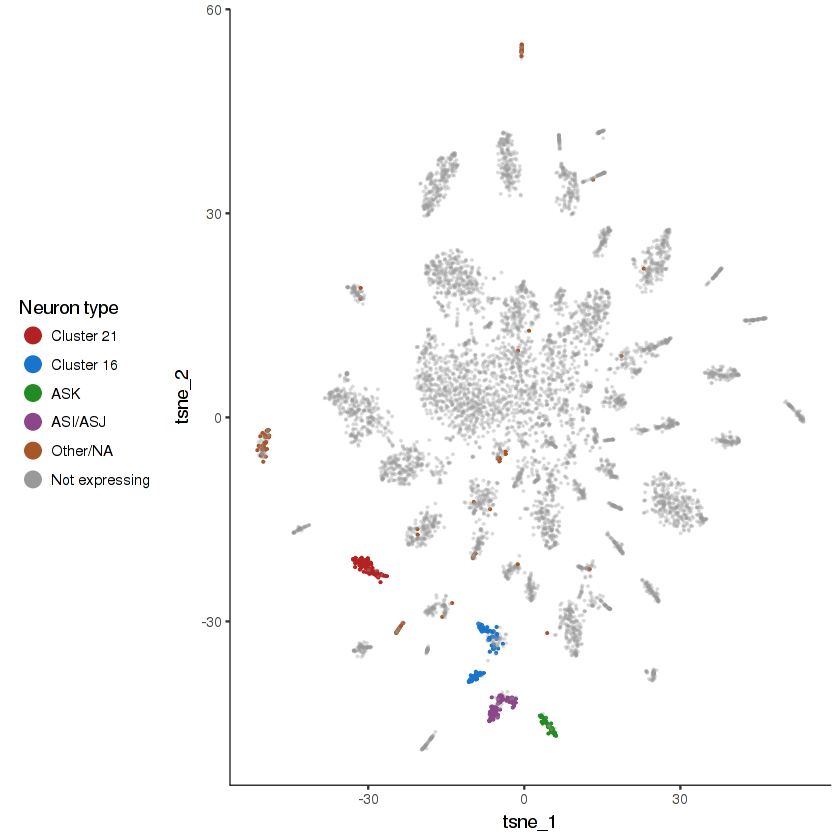

In [33]:
plot.expr(cds.neurons, "R102.2")

`two.set.differential.gene.test` can be used to find DEG between the mystery *R102.2(+)* clusters and other ciliated sensory neurons. If you can figure out what these clusters correspond to, let us know!

In [34]:
neuron.cluster.21.vs.other.CSN.DEG = two.set.differential.gene.test(
    cds.neurons,
    is.neuron.type(cds.neurons, "Cluster 21"),
    !is.neuron.type(cds.neurons, "Cluster 21") & is.cell.type(cds.neurons, "Ciliated sensory neurons"))

neuron.cluster.21.vs.other.CSN.DEG$higher.expr = ifelse(
    neuron.cluster.21.vs.other.CSN.DEG$higher.expr == "Set 1",
    "Cluster 21", "Other CSN")

# of cells in set 1: 107
# of cells in set 2: 735


In [35]:
neuron.cluster.21.vs.other.CSN.DEG %>% filter(higher.expr == "Cluster 21", precision >= 0.8) %>% head(10)

gene,set.1.n.umi,set.2.n.umi,set.1.tpm,set.2.tpm,higher.expr,log2.ratio,precision,recall,f.score
C39D10.2,226,1,5237.910,1.667334,Cluster 21,10.939377,0.9880952,0.7757009,0.8691099
T09B9.3,197,0,3836.121,0.000000,Cluster 21,11.905433,1.0000000,0.6074766,0.7558140
F15A4.5,157,15,3677.812,67.963116,Cluster 21,5.736879,0.8923077,0.5420561,0.6744186
flp-25,100,7,1775.299,44.020086,Cluster 21,5.301349,0.9137931,0.4953271,0.6424242
C18H7.6,118,0,2385.147,0.000000,Cluster 21,11.219863,1.0000000,0.4579439,0.6282051
cdh-3,79,11,1811.618,69.489017,Cluster 21,4.683736,0.8809524,0.3457944,0.4966443
K04D7.6,65,0,1110.520,0.000000,Cluster 21,10.117019,1.0000000,0.2710280,0.4264706
C29F4.3,53,0,1067.368,0.000000,Cluster 21,10.059842,1.0000000,0.2523364,0.4029851
K02E2.1,39,0,1084.714,0.000000,Cluster 21,10.083099,1.0000000,0.2523364,0.4029851
dhs-9,67,15,987.323,53.024505,Cluster 21,4.191836,0.8484848,0.2616822,0.4000000


In [36]:
neuron.cluster.16.vs.other.CSN.DEG = two.set.differential.gene.test(
    cds.neurons,
    is.neuron.type(cds.neurons, "Cluster 16"),
    !is.neuron.type(cds.neurons, "Cluster 16") & is.cell.type(cds.neurons, "Ciliated sensory neurons"))

neuron.cluster.16.vs.other.CSN.DEG$higher.expr = ifelse(
    neuron.cluster.16.vs.other.CSN.DEG$higher.expr == "Set 1",
    "Cluster 16", "Other CSN")

# of cells in set 1: 156
# of cells in set 2: 686


In [37]:
neuron.cluster.16.vs.other.CSN.DEG %>% filter(higher.expr == "Cluster 16") %>% head(10)

gene,set.1.n.umi,set.2.n.umi,set.1.tpm,set.2.tpm,higher.expr,log2.ratio,precision,recall,f.score
F27C1.11,223,367,5302.959,1576.21303,Cluster 16,1.7494202,0.3537118,0.5192308,0.4207792
W05F2.7,137,309,3007.794,1054.38784,Cluster 16,1.5109326,0.3564356,0.4615385,0.4022346
M04B2.6,117,4,2144.256,14.78412,Cluster 16,7.0858594,0.9285714,0.2500000,0.3939394
ocr-2,100,81,2408.536,294.50719,Cluster 16,3.0268916,0.5465116,0.3012821,0.3884298
osm-10,66,32,1209.716,124.87432,Cluster 16,3.2646129,0.7222222,0.2500000,0.3714286
R102.2,363,926,8266.648,3753.48748,Cluster 16,1.1386865,0.2524510,0.6602564,0.3652482
T01D3.1,87,122,1849.955,382.64946,Cluster 16,2.2696298,0.4112903,0.3269231,0.3642857
ida-1,337,1211,7843.130,5636.27821,Cluster 16,0.4764307,0.2234848,0.7564103,0.3450292
lap-2,132,55,2344.214,231.93208,Cluster 16,3.3311228,0.5263158,0.2564103,0.3448276
rps-11,83,230,2013.967,1036.83972,Cluster 16,0.9564565,0.2863636,0.4038462,0.3351064


### Use case 4: re-clustering subsets of the data using t-SNE

In the Cao et al. paper, we found that several of the neuron t-SNE clusters expressed markers of cholinergic neurons such as *unc-17*, *cho-1*, and *cha-1*. Let's perform a sub-clustering of these cholinergic neurons to see if we can get better separation. First, we'll identify which clusters are enriched for cells that express cholinergic markers.

In [38]:
pData(cds.neurons)$any.cholinergic.marker =
    (expresses.gene(cds.neurons, "unc-17") +
     expresses.gene(cds.neurons, "cho-1") +
     expresses.gene(cds.neurons, "cha-1")) > 0

In [39]:
pData(cds.neurons) %>%
    group_by(Cluster) %>%
    summarize(
        n.total = n(), n.cholinergic = sum(any.cholinergic.marker),
        prop.cholinergic = n.cholinergic / n.total) %>%
    inner_join(
        unique(pData(cds.neurons)[, c("Cluster", "neuron.type")]),
        by = "Cluster") %>%
    arrange(-prop.cholinergic) %>%
    head(15)

Cluster,n.total,n.cholinergic,prop.cholinergic,neuron.type
29,305,155,0.5081967,Cholinergic (29)
23,45,19,0.4222222,Cholinergic (23)
3,385,131,0.3402597,Cholinergic (3)
26,261,81,0.3103448,Cholinergic (26)
35,58,16,0.2758621,Cholinergic (35)
36,128,35,0.2734375,Cholinergic (36)
15,65,16,0.2461538,Cholinergic (15)
12,68,14,0.2058824,DVA
24,188,38,0.2021277,Cholinergic (24)
8,117,23,0.1965812,ASI/ASJ


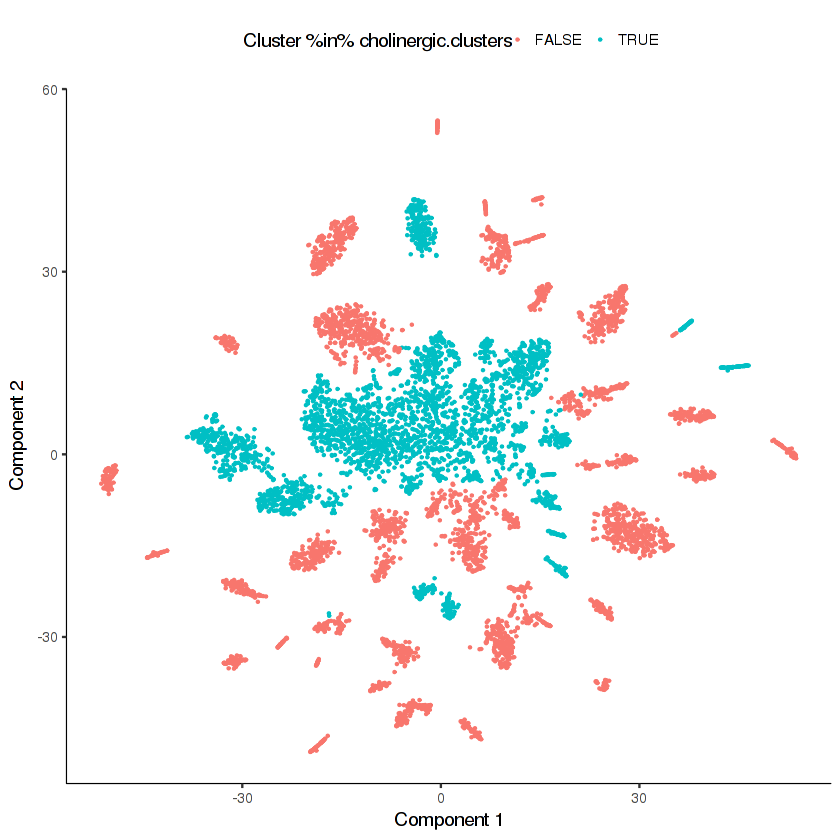

In [40]:
cholinergic.clusters = c(29, 23, 3, 26, 35, 36, 15, 24, 11)
plot_cell_clusters(cds.neurons, color = "Cluster %in% cholinergic.clusters", cell_size = 0.2)

In [41]:
cds.cholinergic = cds.neurons[, pData(cds.neurons)$Cluster %in% cholinergic.clusters]
cat(ncol(cds.cholinergic), "cells in the cds subset", "\n")

cds.cholinergic = estimateSizeFactors(cds.cholinergic)
cds.cholinergic = estimateDispersions(cds.cholinergic) # would take a lot of memory for larger cell sets
cds.cholinergic = detectGenes(cds.cholinergic, 0.1)

3433 cells in the cds subset 


Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message in `[<-.data.frame`(`*tmp*`, res$mu == 0, value = structure(list(:
“provided 1 variable to replace 0 variables”Warning message in `[<-.data.frame`(`*tmp*`, res$mu == 0, value = structure(list(:
“provided 1 variable to replace 0 variables”Removing 324 outliers


The next step is to run a new t-SNE dimensionality reduction on this subset of cells.

In [42]:
system.time({
cds.cholinergic = reduceDimension(
    cds.cholinergic, max_components = 2, norm_method = "log",
    num_dim = 20, reduction_method = 'tSNE', verbose = T)
})

pData(cds.cholinergic)$tsne_1 = reducedDimA(cds.cholinergic)[1,]
pData(cds.cholinergic)$tsne_2 = reducedDimA(cds.cholinergic)[2,]

Remove noise by PCA ...
Reduce dimension by tSNE ...


   user  system elapsed 
161.458   0.733 163.736 

20 principal components looks like its enough for this data. If you don't see an elbow in the scree plot, that means you've used too few principal components.

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

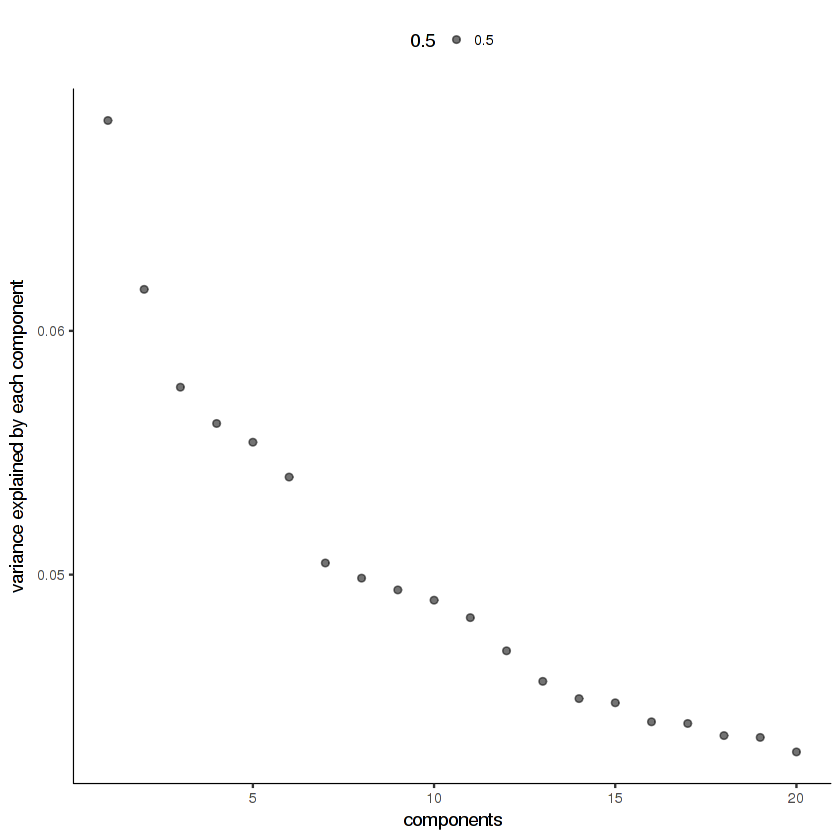

In [43]:
plot_pc_variance_explained(cds.cholinergic)

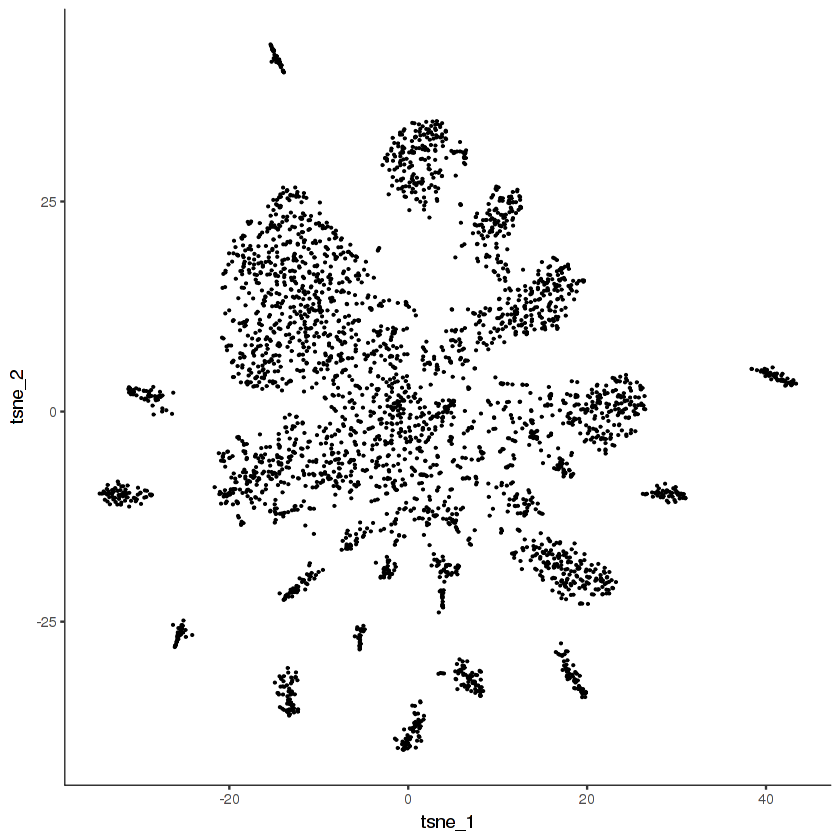

In [44]:
ggplot(pData(cds.cholinergic), aes(x = tsne_1, y = tsne_2)) +
    geom_point(size = 0.1) +
    monocle:::monocle_theme_opts()

Now we'll cluster the cells in the t-SNE space using density peak clustering. In density peak clustering, `rho` measures to the local density of cells and `delta` measures the minimum distance to a region of higher local density. See http://science.sciencemag.org/content/344/6191/1492 for more details. You want to set thresholds on rho and delta that enclose the outlier points in the scatter plot. In my experience, it's usually better to over-cluster than to under-cluster.

In [45]:
cds.cholinergic = clusterCells_Density_Peak(cds.cholinergic)

Distance cutoff calculated to 2.662013 


the length of the distance: 5891028


Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

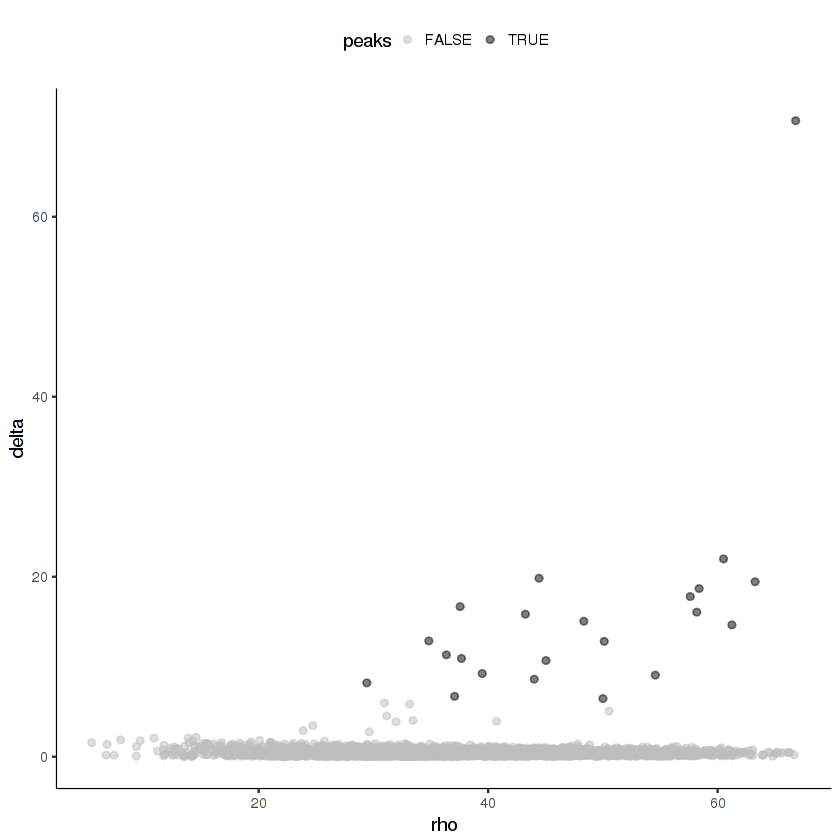

In [46]:
plot_rho_delta(cds.cholinergic, rho_threshold = 10, delta_threshold = 6)

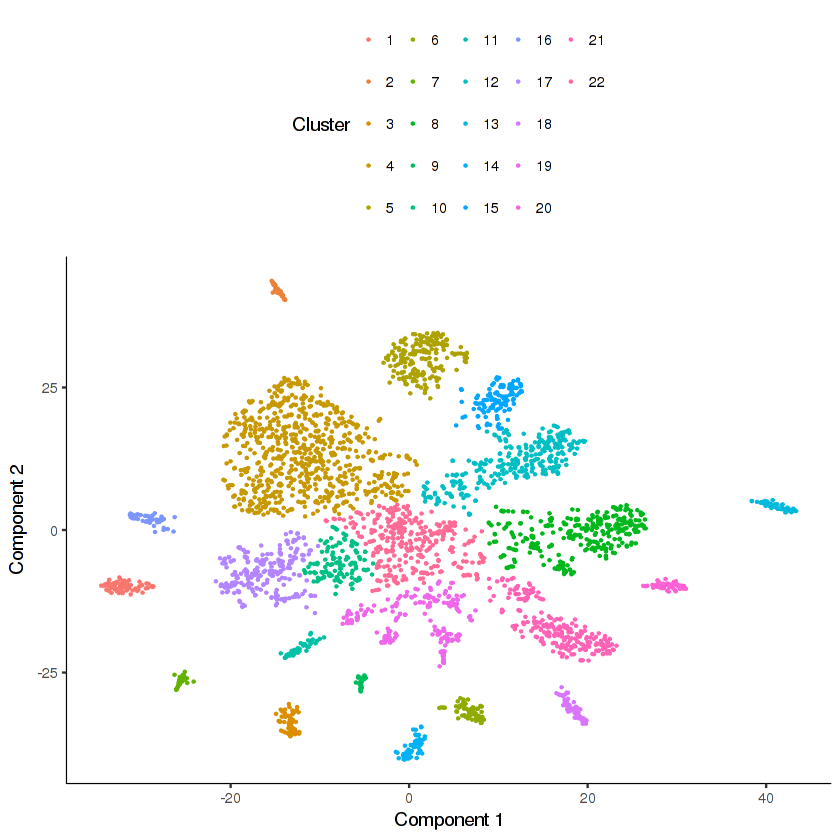

In [47]:
cds.cholinergic = clusterCells_Density_Peak(cds.cholinergic,
    rho_threshold = 10, delta_threshold = 6, skip_rho_sigma = T)
plot_cell_clusters(cds.cholinergic, cell_size = 0.2)

Looks like there are many distinct clusters. Recall that we input only 9 clusters from the cds.neurons t-SNE into this re-clustering. The re-clustering appears to have revealed new potential distinct cell types.

Now would be a good time to save your progress.

In [48]:
save.image("my_analysis_Cao_et_al_data.RData")

Let's find marker genes for each cluster.

In [49]:
cholinergic.clusters = sort(as.integer(unique(pData(cds.cholinergic)$Cluster)))
cholinergic.clusters

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22

In [50]:
DEG.results = lapply(cholinergic.clusters, function(this.cluster) {
    message("Finding markers for cluster ", this.cluster)
    cbind(
        two.set.differential.gene.test(
            cds.cholinergic,
            pData(cds.cholinergic)$Cluster == this.cluster,
            pData(cds.cholinergic)$Cluster != this.cluster),
        data.frame(cluster = this.cluster))
})

Finding markers for cluster 1
# of cells in set 1: 71
# of cells in set 2: 3362
Finding markers for cluster 2
# of cells in set 1: 45
# of cells in set 2: 3388
Finding markers for cluster 3
# of cells in set 1: 64
# of cells in set 2: 3369
Finding markers for cluster 4
# of cells in set 1: 738
# of cells in set 2: 2695
Finding markers for cluster 5
# of cells in set 1: 194
# of cells in set 2: 3239
Finding markers for cluster 6
# of cells in set 1: 67
# of cells in set 2: 3366
Finding markers for cluster 7
# of cells in set 1: 40
# of cells in set 2: 3393
Finding markers for cluster 8
# of cells in set 1: 312
# of cells in set 2: 3121
Finding markers for cluster 9
# of cells in set 1: 34
# of cells in set 2: 3399
Finding markers for cluster 10
# of cells in set 1: 122
# of cells in set 2: 3311
Finding markers for cluster 11
# of cells in set 1: 50
# of cells in set 2: 3383
Finding markers for cluster 12
# of cells in set 1: 291
# of cells in set 2: 3142
Finding markers for cluster 13
#

In [51]:
cholinergic.cluster.markers = do.call(rbind, DEG.results) %>% filter(higher.expr == "Set 1") %>%
    select(
        cluster, gene,
        cluster.n.umi = set.1.n.umi,
        other.n.umi = set.2.n.umi,
        cluster.tpm = set.1.tpm,
        other.tpm = set.2.tpm,
        log2.ratio, precision, recall, f.score) %>%
    arrange(-f.score)

In [52]:
cholinergic.cluster.markers %>% filter(precision >= 0.5) %>% head(10)

cluster,gene,cluster.n.umi,other.n.umi,cluster.tpm,other.tpm,log2.ratio,precision,recall,f.score
7,B0432.14,194,11,10886.411,5.8332893,10.637661,0.9047619,0.9500000,0.9268293
13,nlp-42,298,16,23458.070,18.4945954,10.232794,0.8666667,0.9285714,0.8965517
12,flp-12,1556,120,16722.790,134.5197992,6.947168,0.8478261,0.8041237,0.8253968
13,T04C12.3,168,30,11975.053,31.5493333,8.523188,0.7037037,0.6785714,0.6909091
21,lgc-39,305,77,4677.683,97.0702337,5.575835,0.7019231,0.6186441,0.6576577
1,sem-2,128,63,6240.354,52.4115889,6.868331,0.6615385,0.6056338,0.6323529
2,vglu-2,30,1,2356.216,0.6977763,10.438609,0.9523810,0.4444444,0.6060606
5,Y48C3A.5,339,145,7097.543,147.9313494,5.574600,0.5747664,0.6340206,0.6029412
11,glb-17,81,19,4790.632,16.9955396,8.056433,0.7352941,0.5000000,0.5952381
9,nlp-5,34,24,3552.050,21.1320088,7.326374,0.5500000,0.6470588,0.5945946


In the previous examples for using `plot.expr`, the function used pre-computed expression tables for `cds` and `cds.neurons` to show which cell types / neuron types were expressing a given gene. The following code will set up `plot.expr` so it can show which density peak clusters from this re-clustering analysis express a given gene. You can also use `show.expr.info` with your own clustering.

In [53]:
cholinergic.expr.info = get.expr.info.by.facet(cds.cholinergic, "Cluster")

Computing normalized expression values
Computing gene expression statistics


Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

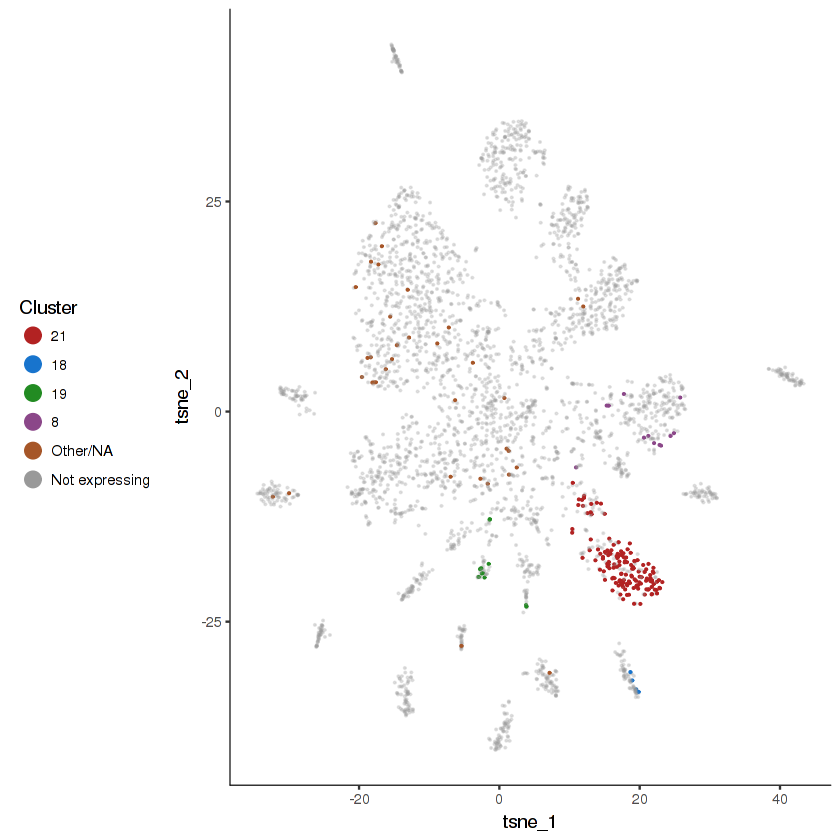

In [54]:
plot.expr(cds.cholinergic, "lgc-39", expr.info = cholinergic.expr.info)

In [56]:
show.expr.info("lgc-39", cholinergic.expr.info) %>% head(10)

facet,tpm,prop.cells.expr,n.umi,total.n.umi.for.facet
21,4677.68319,0.618644068,305,63153
18,244.90291,0.060606061,4,14652
19,232.84907,0.052884615,14,50800
8,217.45530,0.038461538,18,80071
4,155.65487,0.027100271,24,174660
22,129.10174,0.024615385,10,117663
1,79.17593,0.028169014,2,19954
6,60.42661,0.014925373,1,17215
9,56.34438,0.029411765,1,12093
10,30.47108,0.008196721,1,26202


Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

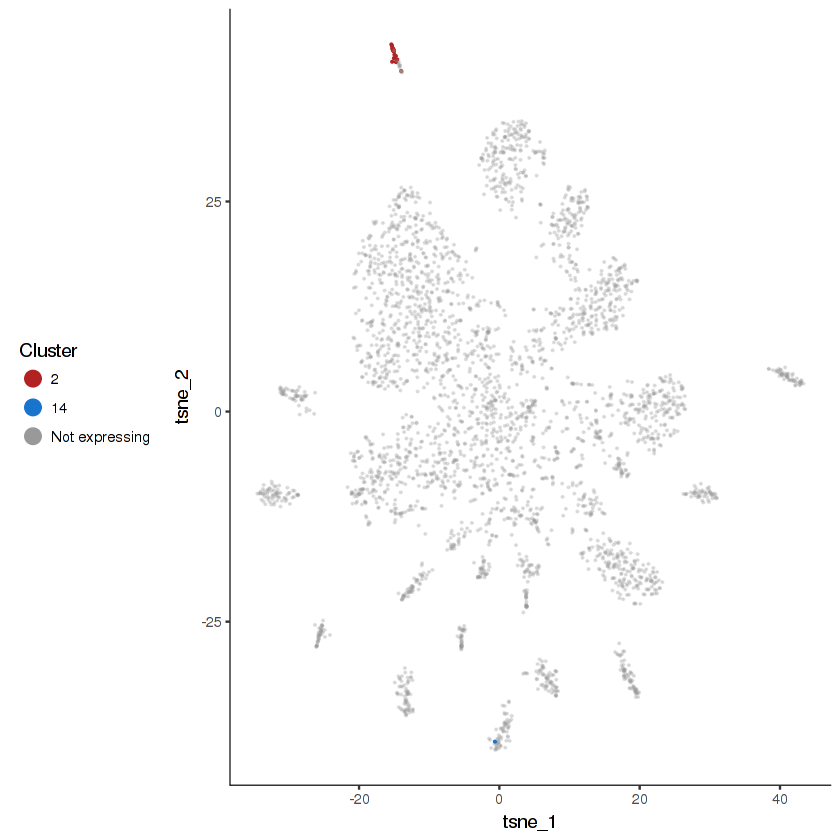

In [57]:
plot.expr(cds.cholinergic, "vglu-2", expr.info = cholinergic.expr.info)

In [58]:
show.expr.info("vglu-2", cholinergic.expr.info) %>% head(10)

facet,tpm,prop.cells.expr,n.umi,total.n.umi.for.facet
2,2356.21566,0.44444444,30,11540
14,37.52486,0.01587302,1,23493
1,0.00000,0.00000000,0,19954
3,0.00000,0.00000000,0,19911
4,0.00000,0.00000000,0,174660
5,0.00000,0.00000000,0,51233
6,0.00000,0.00000000,0,17215
7,0.00000,0.00000000,0,17691
8,0.00000,0.00000000,0,80071
9,0.00000,0.00000000,0,12093


Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

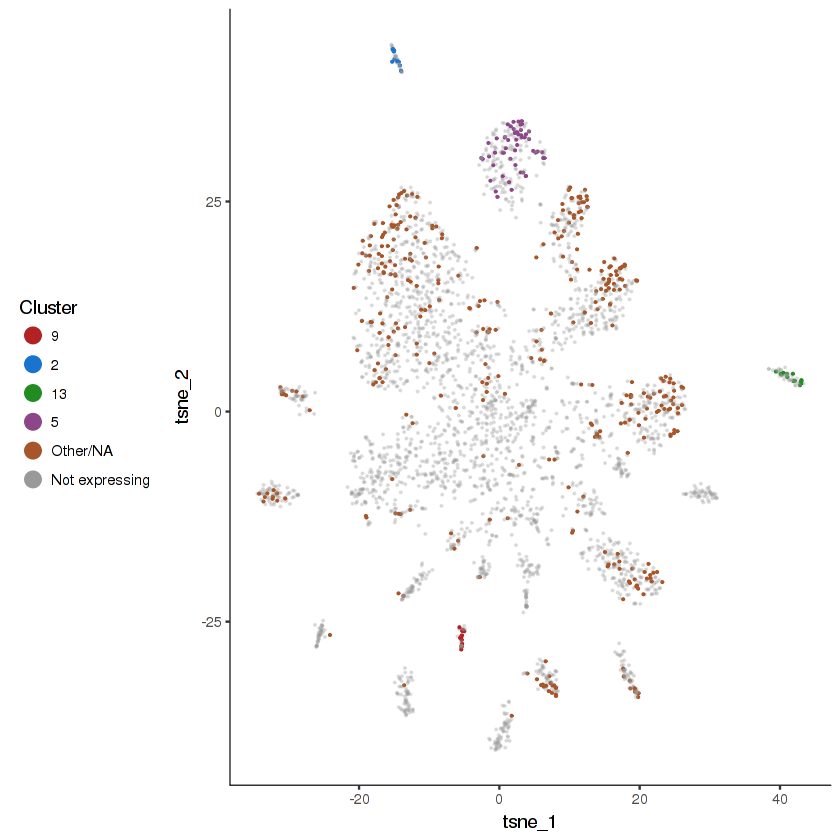

In [59]:
plot.expr(cds.cholinergic, "unc-17", expr.info = cholinergic.expr.info)

In [60]:
show.expr.info("unc-17", cholinergic.expr.info) %>% head(10)

facet,tpm,prop.cells.expr,n.umi,total.n.umi.for.facet
9,3200.3642,0.3823529,44,12093
2,2944.3520,0.2888889,27,11540
13,2128.1049,0.2500000,29,13140
5,2087.7739,0.2731959,119,51233
15,1992.1189,0.2941176,62,31426
6,1721.6386,0.2686567,34,17215
8,1527.0847,0.1826923,126,80071
4,1344.6852,0.1585366,235,174660
12,1114.1395,0.1718213,123,97104
16,886.1635,0.1923077,16,19103


In [84]:
ggsave("plots/plot.expr.example.pdf",
    plot = plot.expr(cds, "lin-12", cell_size = 0.004) +
       ggtitle("lin-12 expression") +
       scale_alpha_manual(values = c(0.1, 1)) +
       theme_void() +
       monocle:::monocle_theme_opts() +
       theme(plot.title = element_text(size = 8, margin = margin(10, 0, 0, 0)),
             legend.title = element_text(size = 6),
             legend.text = element_text(size = 6),
             legend.margin = margin(0, -10, 0, 10),
             legend.key.width=unit(0.15, "in"),
             legend.key.height=unit(0.15, "in"),
             legend.position = "left"),
    units = "in", width = 3.5, height = 3.0)

Scale for 'alpha' is already present. Adding another scale for 'alpha', which
will replace the existing scale.


In [77]:
plot.expr

function(cds, gene, thresh = 1, cell_size = 0.1, expr.info = NULL) 
{
    cds.name = deparse(substitute(cds))
    
    gene.id = get.gene.id(gene, cds)
    pData(cds)$tmp.expr = exprs(cds)[gene.id, ] >= thresh
    
    facet = NULL
    if (!is.null(expr.info)) {
        facet = expr.info$facet
        facet.levels = as.character(head(
            subset(show.expr.info(gene, expr.info), n.umi > 0)$facet, 4))
    } else {
        if (cds.name == "cds") {
            facet = "cell.type"
            facet.levels = as.character(head(
                    subset(show.expr.info(gene, cell.type.expr.info), n.umi > 0)$facet, 4))
        } else if (cds.name == "cds.neurons") {
            facet = "neuron.type"
            facet.levels = as.character(head(
                    subset(show.expr.info(gene, neuron.type.expr.info), n.umi > 0)$facet, 4))
        }
    }
    
    if (is.null(facet)) {
        plot = ggplot(pData(cds), aes(x = tsne_1, y = tsne_2, color = tmp.expr, alpha = tmp.expr)) +
            geom_point(size = cell_size) +
            scale_color_manual(values = c("grey60", "firebrick"), labels = c("No", "Yes")) +
            scale_alpha_manual(values = c(0.25, 1.0)) +
            guides(color = guide_legend(title = paste("Expresses ", gene, "?", sep=""),
                                        override.aes = list(size = 4)),
                   alpha = F) +
            monocle:::monocle_theme_opts() +
            theme(legend.position = "left")
    } else {
        facet.name = paste(toupper(substring(facet, 1, 1)), substring(facet, 2), sep = "")
        facet.name = gsub("[._]", " ", facet.name)

        pData(cds)$tmp.facet = pData(cds)[, facet]

        pData(cds)$tmp.expr = with(pData(cds), ifelse(
            tmp.expr & tmp.facet %in% facet.levels, tmp.facet,
                ifelse(tmp.expr,
                    ifelse((!is.na(cell.type) & cell.type == "Failed QC") | cell %in% low.coverage.cells,
                        "Failed QC", "Other/NA"), "Not expressing")))

        pData(cds)$tmp.expr = factor(pData(cds)$tmp.expr,
            levels = c(facet.levels, "Other/NA", "Not expressing", "Failed QC"))

        colors = c("firebrick", "dodgerblue3", "forestgreen", "orchid4", "#FF7F00", "gold", "#FFFF33", "#F781BF")                

        plot = ggplot(pData(cds), aes(x = tsne_1, y = tsne_2, color = tmp.expr,
                                      alpha = tmp.expr != "Not expressing")) +
            geom_point(size = cell_size)

        if ("Other/NA" %in% unique(pData(cds)$tmp.expr))
            plot = plot +
                scale_color_manual(values = c(colors[1:length(facet.levels)], "#A65628", "grey60", "lightsteelblue4"))
        else
            plot = plot +
                scale_color_manual(values = c(colors[1:length(facet.levels)], "grey60", "lightsteelblue4"))

        plot = plot +
            scale_alpha_manual(values = c(0.25, 1.0)) +
            guides(color = guide_legend(title = facet.name, override.aes = list(size = 4)),
                   alpha = F) +
            monocle:::monocle_theme_opts() +
            theme(legend.position = "left")
    }
    
    pData(cds)$tmp.expr = NULL
    pData(cds)$tmp.facet = NULL

    return(plot)
}